In [88]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from transformers import AutoModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
import torch
dvu.set_style()
import sys
sys.path.append('..')
import pandas as pd
import analyze_helper
from experiments import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
import embgam

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# rs = data.load_fitted_results()
# rs.to_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))

rs = pd.read_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))
rr, r_sem = analyze_helper.average_seeds(rs)
rs.head()

,checkpoint,ngrams,ngrams_test,subsample,all,norm,dataset,seed,layer,parsing,ignore_cache,padding,num_features,acc_train,acc_val
0,glove_wordvecs,1,,-1,,,emotion,1,pooler_output,,True,True,300,0.739563,0.732500
1,glove_wordvecs,1,,-1,,,emotion,2,pooler_output,,True,True,300,0.738500,0.729500
2,glove_wordvecs,1,,-1,,,emotion,3,pooler_output,,True,True,300,0.738625,0.731000
3,glove_wordvecs,1,,100,,,emotion,1,pooler_output,,True,True,300,0.743750,0.727500
0,glove_wordvecs,1,,-1,,,financial_phrasebank,1,pooler_output,,True,True,300,0.907047,0.804386


In [90]:
dset = 'sst2'
dataset, dataset_key_text = embgam.data.process_data_and_args(dset)
dval = dataset['validation']

/home/chansingh/.embgam/lib/python3.8/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Using custom data configuration default
Found cached dataset sst2 (/home/chansingh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

## Emb-GAM model

In [91]:
row = pkl.load(open(oj(config.results_dir, 'sst_bert_finetuned_ngrams=2.pkl'), 'rb'))

/home/chansingh/.embgam/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegressionCV from version 0.24.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [97]:
tokenizer = AutoTokenizer.from_pretrained(row.checkpoint) # for actually passing things to the model
model = AutoModel.from_pretrained(row.checkpoint)
logistic = row.model

seqs = dval['sentence'] # ['not bad', 'not', 'very', 'good', 'not very', 'very good', 'not very good']
device = 'cuda'
tokens = tokenizer(seqs, padding=True, truncation=True, return_tensors="pt").to(device)
model = model.to(device)
with torch.no_grad():
    output = model(**tokens) # has two keys, 'last_hidden_state', 'pooler_output'
embs = output[row.layer].cpu().detach().numpy()
# pkl.dump(embs, open('../results/embs_sst_unigram_bigram.pkl', 'wb'))

Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [98]:
preds_proba = logistic.predict_proba(embs)
preds = logistic.predict(embs)

## DNN baseline

In [101]:
checkpoints = {
    'emotion': 'nateraw/bert-base-uncased-emotion',
    'rotten_tomatoes': 'textattack/bert-base-uncased-rotten_tomatoes',
    'financial_phrasebank': 'ahmedrachid/FinancialBERT-Sentiment-Analysis',
    'sst2': 'textattack/bert-base-uncased-SST-2',
}
dnn = pipeline('text-classification', model=checkpoints[dset], device=0)
def score(ex):
    d = dnn(ex['sentence'])
    return {'score': [out['score'] for out in d],
            'label': [out['label'] for out in d]}
dval_dnn = dval.map(score)

  0%|          | 0/872 [00:00<?, ?ex/s]

/home/chansingh/.embgam/lib/python3.8/site-packages/transformers/pipelines/base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [121]:
preds_proba_dnn = np.array(dval_dnn['score']).flatten()
pred_dnn = np.array(list(map(dnn.model.config.label2id.get,
                             np.array(dval_dnn['label']).flatten())))

## Look at joint performance 

In [136]:
labs = np.array(dataset['validation']['label'])
acc = (preds == labs).mean()
acc_dnn = np.mean(np.array(pred_dnn) == labs)
n = labs.size
print('acc', acc, 'acc_dnn', acc_dnn)

acc 0.805045871559633 acc_dnn 0.9243119266055045


In [130]:
args = np.argsort(np.abs(preds_proba.max(axis=1)))[::-1]
accs_sorted = preds[args] == labs[args]
accs_sorted_dnn = pred_dnn[args] == labs[args]
num_correct_cum = np.cumsum(accs_sorted)
num_correct_cum_dnn = np.cumsum(accs_sorted_dnn)

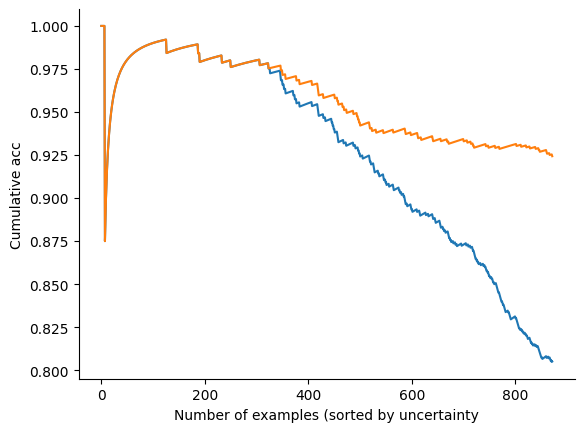

In [131]:
plt.plot(num_correct_cum / np.arange(1, len(accs_sorted) + 1))
plt.plot(num_correct_cum_dnn / np.arange(1, len(accs_sorted_dnn) + 1))
plt.ylabel('Cumulative acc')
plt.xlabel('Number of examples (sorted by uncertainty')
plt.show()

In [132]:
num_correct_combined = num_correct_cum + (np.max(num_correct_cum_dnn) - num_correct_cum_dnn)

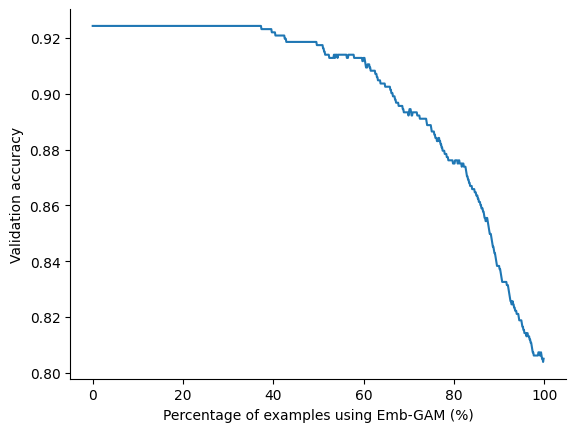

In [143]:
plt.plot(np.arange(n) / n * 100, num_correct_combined / n)
plt.xlabel('Percentage of examples using Emb-GAM (%)')
plt.ylabel('Validation accuracy')
plt.show()